# Note, for this program, we are using the allStar-dr17-synspec_rev1.fits file. This is because the original DR17 release of the allStar file had mistakes with the LSF on over 100k LCO stars. This file accounts for these issues, and includes these additional objects

In [1]:
#Importing packages and downloading the allStar file

import astropy
from astropy.io import fits
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


hdulist = fits.open("allStar-dr17-synspec_rev1.fits")
hdu = hdulist[1]
hdu.header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 5410 / length of dimension 1                          
NAXIS2  =               733901 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                  234 / number of table fields                         
TTYPE1  = 'FILE    '                                                            
TFORM1  = '64A     '                                                            
TTYPE2  = 'APOGEE_ID'                                                           
TFORM2  = '30A     '                                                            
TTYPE3  = 'TARGET_ID'       

In [ ]:
#Extracting pertinent information about the objects

SDSSID = hdu.header['TTYPE2']
SDSSIDdata = hdu.data[SDSSID]

FieldID = hdu.header['TTYPE8']
FieldIDdata = hdu.data[FieldID]

Telescope = hdu.header['TTYPE6']
Telescopedata = hdu.data[Telescope]

GAIAID = hdu.header['TTYPE83']
GAIAIDdata = hdu.data[GAIAID]

ra = hdu.header['TTYPE10']
radata = hdu.data[ra]
#right accension

d = hdu.header['TTYPE11']
ddata = hdu.data[d]
#declination

teff = hdu.header['TTYPE129']
teffdata = hdu.data[teff]
#effective temperature

logg = hdu.header['TTYPE131']
loggdata = hdu.data[logg]
#surface gravity

nvisits = hdu.header['TTYPE57']
nvisitsdata = hdu.data[nvisits]
#number of visits (doppler)

vscatter = hdu.header['TTYPE65']
vscatterdata = hdu.data[vscatter]
#v_scatter parameter

vsini = hdu.header['TTYPE139']
vsinidata = hdu.data[vsini]
#vsin(i) paramater

SLs = hdu.header['TTYPE76']
SLsdata = hdu.data[SLs]
#number of spectral lines from doppler fit

carbon_abundance = hdu.header['TTYPE142']
nitrogen_abundance = hdu.header['TTYPE153']
cdata = hdu.data[carbon_abundance]
ndata = hdu.data[nitrogen_abundance]
#metallicities of C and N

S_N = hdu.header['TTYPE59']
S_N_data = hdu.data[S_N]
#signal-to-noise

In [ ]:
#Reducing the data files to DF sizing


teff_1 = teffdata.reshape(733901, 1)
logg_1 = loggdata.reshape(733901, 1)
nvisits_1 = nvisitsdata.reshape(733901, 1)
vscatter_1 = vscatterdata.reshape(733901, 1)
vsini_1 = vsinidata.reshape(733901,1)
SLs_1 = SLsdata.reshape(733901,1)
SDSSID_1 = SDSSIDdata.reshape(733901,1)
GAIAID_1 = GAIAIDdata.reshape(733901,1)
FieldID_1 = FieldIDdata.reshape(733901,1)
Telescope_1 = Telescopedata.reshape(733901,1)
S_N_1 = S_N_data.reshape(733901,1)
ra_1 = radata.reshape(733901,1)
d_1 = ddata.reshape(733901,1)
c_1 = cdata.reshape(733901,1)
n_1 = ndata.reshape(733901,1)

teff_final = np.concatenate(teff_1)
logg_final = np.concatenate(logg_1)
nvisits_final = np.concatenate(nvisits_1)
vscatter_final = np.concatenate(vscatter_1)
vsini_final = np.concatenate(vsini_1)
SLs_final = np.concatenate(SLs_1)
SDSSID_final = np.concatenate(SDSSID_1)
GAIAID_final = np.concatenate(GAIAID_1)
FieldID_final = np.concatenate(FieldID_1)
Telescope_final = np.concatenate(Telescope_1)
S_N_final = np.concatenate(S_N_1)
ra_final = np.concatenate(ra_1)
d_final = np.concatenate(d_1)
c_final = np.concatenate(c_1)
n_final = np.concatenate(n_1)

In [ ]:
#Initialize the DF

df1 = pd.DataFrame({'field':FieldID_final,'telescope': Telescope_final,'sdss-id':SDSSID_final, 'gaia-id': GAIAID_final, 'right ascension':ra_final, 'declination': d_final, 'teff': teff_final, 
                    'logg': logg_final, 'nvisits': nvisits_final, 
                    'vscatter': vscatter_final, 'vsini': vsini_final, 'numSLs': SLs_final,'avg signal to noise':S_N_final, 'C_Fe_Ratio': c_final, 'N_Fe_Ratio': n_final})

In [5]:
#Reduce the initial DF to only those with the following parameter values
df2 = df1.query('nvisits>=2 & vscatter >= 1 & vsini > 10 & teff >3500 & teff <6000 & logg >3.6 & logg<4.5 & numSLs == 1')

In [6]:
#Calculating metallicity in terms of C/N and adding it as a new column into the final DF

C_N = df2.C_Fe_Ratio - df2.N_Fe_Ratio

df3 = pd.DataFrame({"C_N": C_N})
df4 = pd.concat([df2, df3], axis=1, join="inner")

<IPython.core.display.Javascript object>


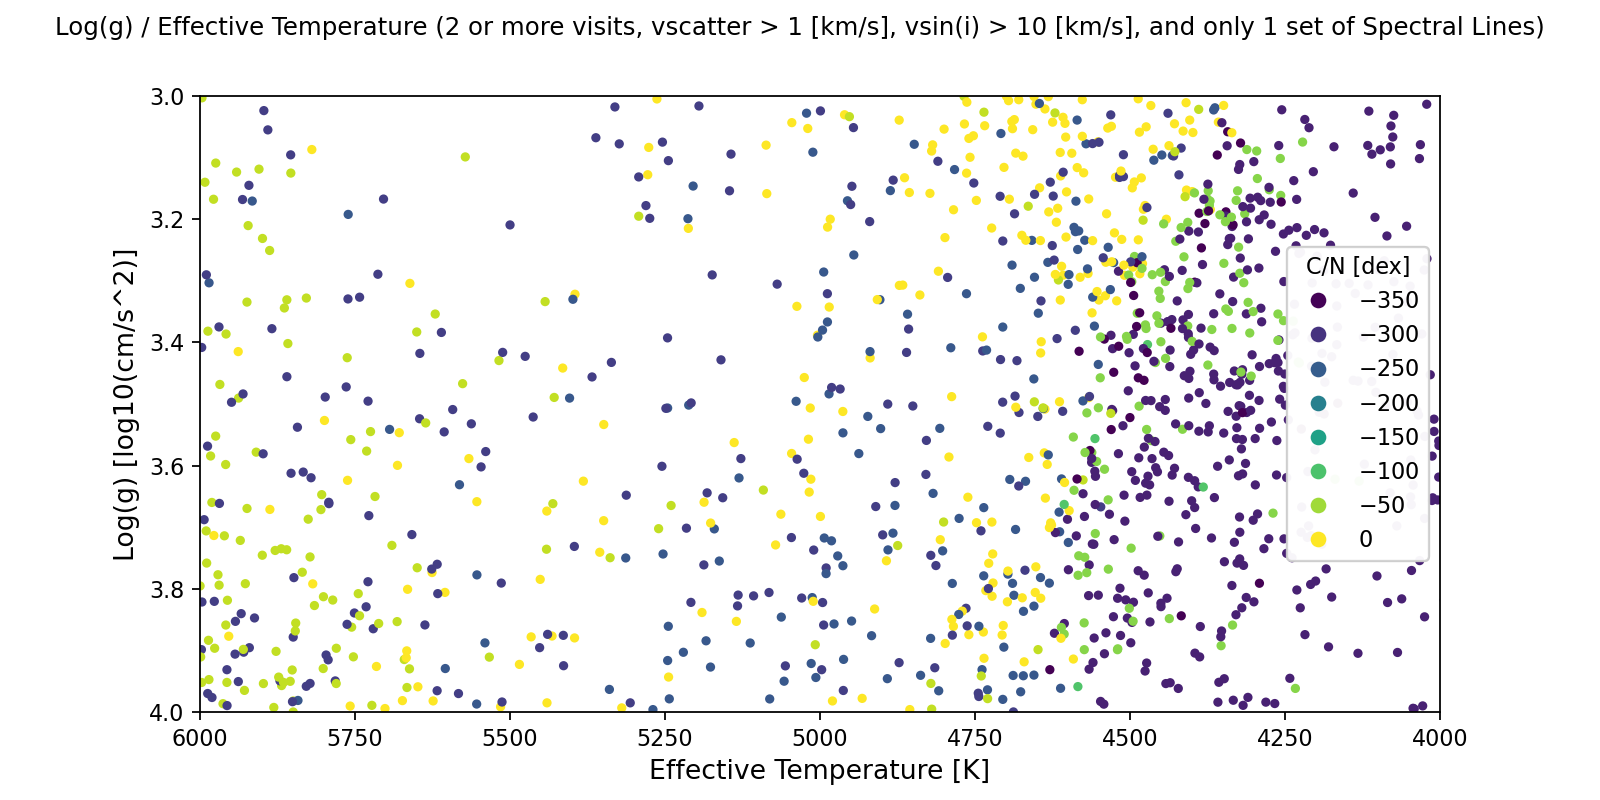

In [7]:
#Plotting

%matplotlib notebook

fig, ax = plt.subplots(figsize=(10, 5))
sizer = 10
scatter = ax.scatter(df4.teff, df4.logg, c= df4.C_N, label = 'Teff/Logg', s=sizer)
ax.set_xlim([6000,4000])
ax.set_ylim([4, 3])
fig.suptitle('Log(g) / Effective Temperature (2 or more visits, vscatter > 1 [km/s], vsin(i) > 10 [km/s], and only 1 set of Spectral Lines)', fontsize=11)
plt.xlabel('Effective Temperature [K]', fontsize=12)
plt.ylabel('Log(g) [log10(cm/s^2)]', fontsize=12)
legend = ax.legend(*scatter.legend_elements(),loc="center right", title="C/N [dex]")
ax.add_artist(legend)
fig.show()

In [8]:
#Export to CSV

df4.to_csv(r'ReducedListofAPOGEEStars(dr17).csv')